# Which populations are at risk of contracting COVID-19?

### Never felt in such a hurry to see  ....

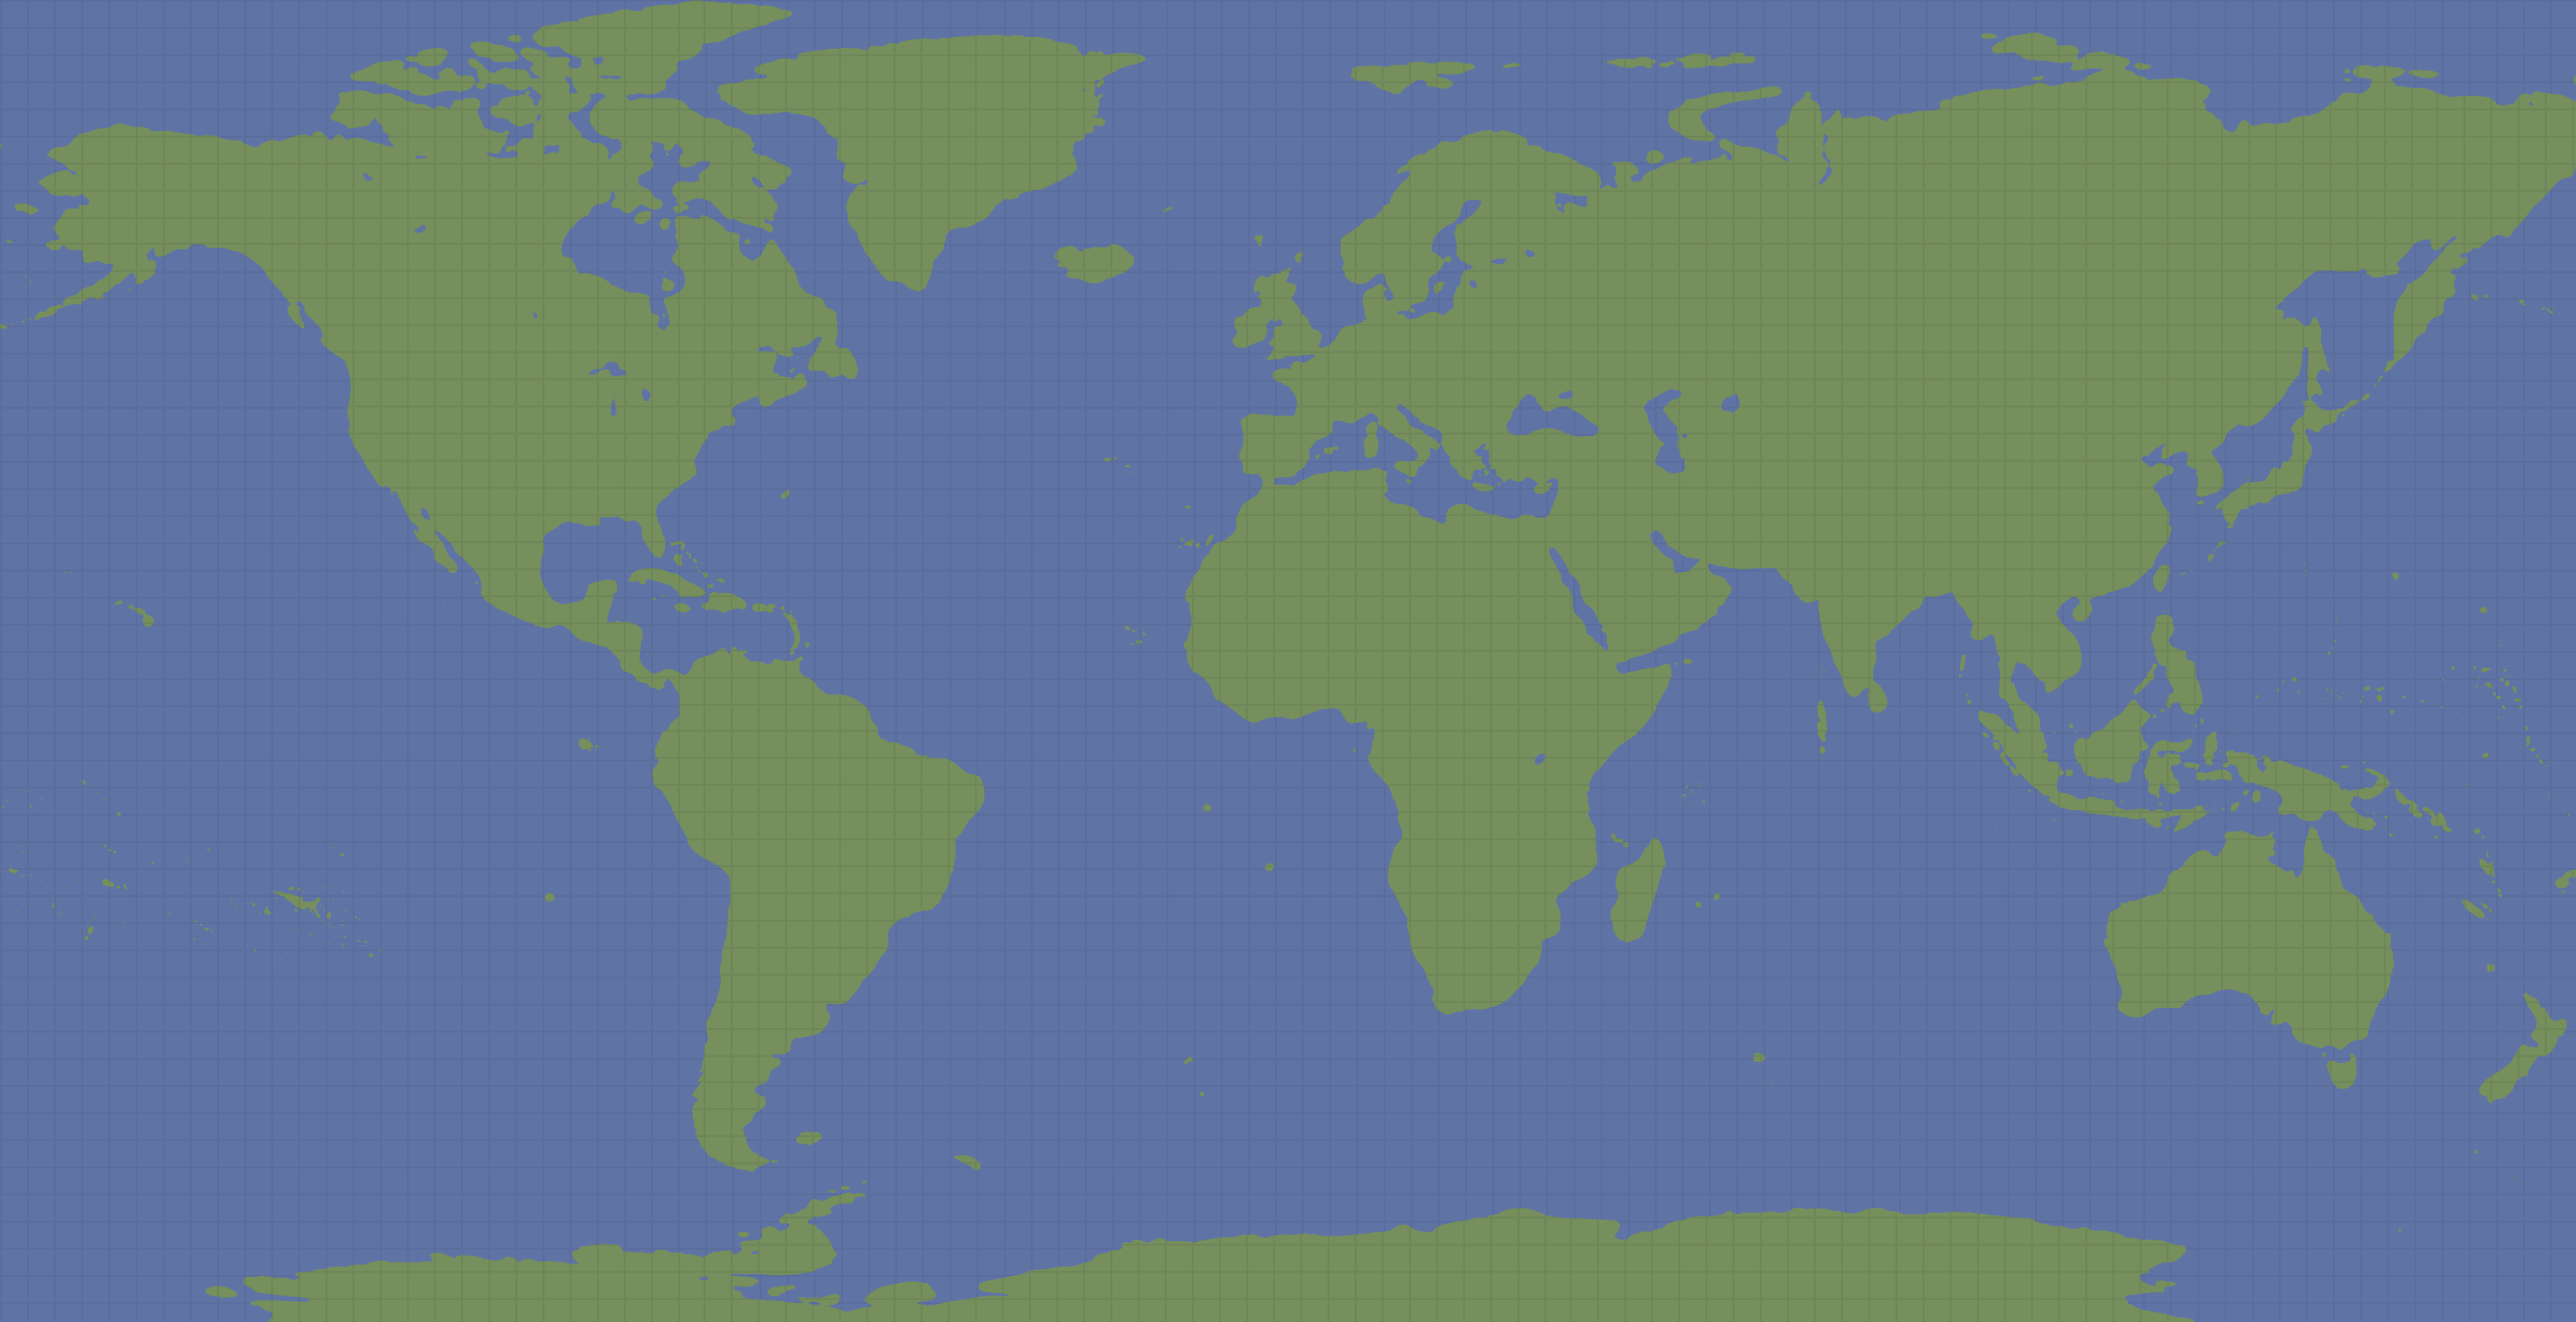

## Acknowledgements

### kernels
* https://www.kaggle.com/aestheteaman01/demographics-observation-for-pandemic-escalation

### Resources
* https://analyticsindiamag.com/beginners_guide_geographical_plotting_with_plotly/
* https://plotly.com/python/choropleth-maps/
* https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html

<a class="anchor" id="0.1"></a>
## Table of Contents

1. [Libraries, Mem Reduction, Reading Files](#1)
1. [Analyzing Tests Performed data](#2)
    -  [2.1 Total Tests vs Entity](#2.1)
    -  [2.2 Total Tests vs Date](#2.2)  
    -  [2.3 Total Tests Per Million vs Entity](#2.3)  
    -  [2.4 Total Tests Per Million vs Date](#2.4) 
1. [Analyzing Confirmed Cases](#3)
    -  [3.1 Total Confirmed Cases vs Entity](#3.1)
        -  [3.1.1 High Confirmed Cases - Top 10](#3.1.1) 
        -  [3.1.2 Relatively lesser confirmed cases - Top 10](#3.1.2)         
        -  [3.1.3 Relatively lesser confirmed cases - Next 10](#3.1.3)  
    -  [3.2 Total Confirmed Cases Per Million vs Entity](#3.2)
        -  [3.2.1 High Confirmed Cases per Million - Top 10](#3.2.1) 
        -  [3.2.2 High Confirmed Cases per Million - Next 10](#3.2.2)         
1. [Hospitalization](#4)
    -  [4.1 New ICU vs Location](#4.1)  
    -  [4.2 Deaths vs Location](#4.2)      
        -  [4.2.1 Deaths Top 10 vs Location](#4.2.1)    

## 1. Libraries, Mem Reduction, Reading Files <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib as p
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as gobj
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)

import plotly.express as px       
import plotly.offline as py       
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
tests_by_country = import_data('/kaggle/input/uncover/UNCOVER/our_world_in_data/total-covid-19-tests-performed-by-country.csv')
tests_per_million = import_data('/kaggle/input/uncover/UNCOVER/our_world_in_data/total-covid-19-tests-performed-per-million-people.csv')
tests_vs_confirmed = import_data('/kaggle/input/uncover/UNCOVER/our_world_in_data/tests-conducted-vs-total-confirmed-cases-of-covid-19.csv')
testspermillion_vs_confirmed = import_data('/kaggle/input/uncover/UNCOVER/our_world_in_data/per-million-people-tests-conducted-vs-total-confirmed-cases-of-covid-19.csv')
hospitalization = import_data('../input/uncover/UNCOVER/ihme/2020_03_30/Hospitalization_all_locs.csv')

## 2. Analyzing Tests Performed data <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
display(tests_by_country.head(), tests_per_million.head())

In [ ]:
tests_merged = pd.merge(tests_by_country, tests_per_million, on='entity')
tests_merged = tests_merged.drop(['code_y', 'date_y'], axis = 1)
tests_merged = tests_merged.rename(columns = {'code_x': 'code','date_x':'date'}) 
tests_merged.head()

## 2.1 Total Tests vs Entity <a class="anchor" id="2.1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
sorted_by_tests = tests_merged.sort_values('total_covid_19_tests')
plt.figure(figsize=(30,25))
plt.barh('entity','total_covid_19_tests', data=sorted_by_tests)
plt.xlabel("total_covid_19_tests", size=15)
plt.ylabel("Salary in US Dollars", size=15)
plt.tick_params(axis='x', rotation = 90, labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.title("total_covid_19_tests vs entity", size=18)

In [ ]:
data = dict(type = 'choropleth',
            locations = tests_merged['entity'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Rainbow',
            text= tests_merged['entity'],
            z=tests_merged['total_covid_19_tests'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':'Tests Performed','len':0.25,'lenmode':'fraction'})
layout = dict(geo = dict(scope='world'), width = 1500, height = 1000)

worldmap = gobj.Figure(data = [data],layout = layout)
iplot(worldmap)

#### Tests performed across entire Australia covering it's 8 provinces. I'm guessing 'Australia' below represents the Northern Territory

In [ ]:
tests_aus = tests_merged[tests_merged['entity'].str.contains('Australia')]
tests_aus

## 2.2 Total Tests vs Date <a class="anchor" id="2.2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
sorted_by_date = tests_merged.sort_values('date')
plt.figure(figsize=(25,10))
plt.barh('date','total_covid_19_tests', data=sorted_by_date)
plt.xlabel("total_covid_19_tests", size=15)
plt.ylabel("date", size=15)
plt.tick_params(axis='x',  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.title("total_covid_19_tests vs date", size=18)

#### The tests performed reduced dramatically in the following couple of weeks post 02/24, picked up in the end of 2nd week of March and then reached almost from where it started on 03/20
#### On observing the data for the lesser tests performed dates (below) Spain, Belgium, Sweden, Israel stood out - all of them port based. Was there a delay in realizing the impact or occurrences due to any sort of port based commutes?

In [ ]:
date_list = ['2020-03-05', '2020-03-07', '2020-03-10', '2020-03-13', '2020-03-17', '2020-03-18']
tests_performed_lesser_freq = tests_merged[tests_merged['date'].isin(date_list)].sort_values('total_covid_19_tests', ascending = False)
tests_performed_lesser_freq.head(10)

## 2.3 Total Tests Per Million vs Entity <a class="anchor" id="2.3"></a>

[Back to Table of Contents](#0.1)

In [ ]:
sorted_by_testspermillion = tests_merged.sort_values('total_covid_19_tests_per_million_people')
plt.figure(figsize=(30,25))
plt.barh('entity','total_covid_19_tests_per_million_people', data=sorted_by_testspermillion)
plt.xlabel("total_covid_19_tests", size=15)
plt.ylabel("entity", size=15)
plt.tick_params(axis='x', rotation = 90, labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.title("total_covid_19_tests_per_million_people vs entity", size=18)

In [ ]:
data = dict(type = 'choropleth',
            locations = tests_merged['entity'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Rainbow',
            text= tests_merged['entity'],
            z=tests_merged['total_covid_19_tests_per_million_people'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':'Tests Performed per Million','len':0.25,'lenmode':'fraction'})
layout = dict(geo = dict(scope='world'), width = 1500, height = 1000)

worldmap = gobj.Figure(data = [data],layout = layout)
iplot(worldmap)

#### Looking at the Tests Performed against Test Performed per Million Australia appears to be well covered. The fact that all the 8 provinces are involved could be the factor.
#### For a lot of Tests Performed for China and Russia, the Test Performed per Million is relatively less. It could indicate that only focused region/s being covered.

## 2.4 Total Tests Per Million vs Date <a class="anchor" id="2.4"></a>

[Back to Table of Contents](#0.1)

In [ ]:
sorted_by_datepm = tests_merged.sort_values('date')
plt.figure(figsize=(25,10))
plt.barh('date','total_covid_19_tests_per_million_people', data=sorted_by_datepm)
plt.xlabel("total_covid_19_tests_per_million_people", size=15)
plt.ylabel("date", size=15)
plt.tick_params(axis='x',  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.title("total_covid_19_tests_per_million_people vs date", size=18)

In [ ]:
date_list = ['2020-03-10']
tests_performed_pm_lesser_freq = tests_merged[tests_merged['date'].isin(date_list)].sort_values('total_covid_19_tests_per_million_people', ascending = False)
tests_performed_pm_lesser_freq.head(10)

## 3. Analyzing Confirmed Cases <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [ ]:
display(tests_vs_confirmed.head(), testspermillion_vs_confirmed.head())

## 3.1 Total Confirmed Cases vs Entity <a class="anchor" id="3.1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
grouped_by_entity = tests_vs_confirmed.groupby('entity').sum()['total_confirmed_cases_of_covid_19_cases'].sort_values(ascending=False).to_frame(name = 'Sum').reset_index()
grouped_by_entity

#### Removing the entry for 'World' and all the 0 confirmed entries 

In [ ]:
#### Removing the entry for 'World' and all the 0 confirmed entries 
grouped_by_entity = grouped_by_entity[(grouped_by_entity['entity'] != 'World')]
grouped_by_entity = grouped_by_entity[(grouped_by_entity['Sum'] != 0)]
grouped_by_entity

In [ ]:
grouped_by_entity = grouped_by_entity.sort_values('Sum')
plt.figure(figsize=(40,50))
plt.barh('entity','Sum', data=grouped_by_entity)
plt.xlabel("total_confirmed_cases_of_covid_19_cases", size=15)
plt.ylabel("entity", size=15)
plt.tick_params(axis='x',  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.title("total_confirmed_cases_of_covid_19_cases vs entity", size=25)

#### Although the confirmed cases are relatively lesser in majority of the world but the below depiction shows the spread and the skewness of the confirmed cases 

In [ ]:
data = dict(type = 'choropleth',
            locations = grouped_by_entity['entity'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Rainbow',
            text= grouped_by_entity['entity'],
            z=grouped_by_entity['Sum'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':'Confirmed Cases by Entity','len':0.25,'lenmode':'fraction'})
layout = dict(geo = dict(scope='world'), width = 1500, height = 1000)

worldmap = gobj.Figure(data = [data],layout = layout)
iplot(worldmap)

In [ ]:
# Not as pretty and effective as the original kernal I took help from. Tweaked a little bit.

#Creating the interactive map
py.init_notebook_mode(connected=True)

#GroupingBy the dataset for the map
formated_gdf = tests_vs_confirmed.groupby(['date', 'entity']).sum()['total_confirmed_cases_of_covid_19_cases'].to_frame(name = 'sum').reset_index()
formated_gdf['sum'] = formated_gdf['sum'].fillna(0)
formated_gdf['date'] = pd.to_datetime(formated_gdf['date'])
formated_gdf['date'] = formated_gdf['date'].dt.strftime('%m/%d/%Y')

formated_gdf['log_ConfirmedCases'] = np.log(formated_gdf['sum'] + 2)

#Plotting the figure
fig = px.choropleth(formated_gdf, locations="entity", locationmode='country names', 
                     color="log_ConfirmedCases", hover_name="entity",projection="mercator",
                     animation_frame="date",width=1000, height=800,
                     color_continuous_scale=px.colors.sequential.Viridis,
                     title='Confirmed Cases vs Entity')

#Showing the figure
fig.update(layout_coloraxis_showscale=True)
py.offline.iplot(fig)

## 3.1.1 High Confirmed Cases - Top 10 <a class="anchor" id="3.1.1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
high_confirmed_list = ['China', 'Italy', 'Iran', 'United States', 'Spain', 'Germany', 'South Korea', 'France', 'Switzerland', 'United Kingdom']
high_confirmed_cases = tests_vs_confirmed[tests_vs_confirmed['entity'].isin(high_confirmed_list)]

In [ ]:
#Creating the interactive map
py.init_notebook_mode(connected=True)

#GroupingBy the dataset for the map
gdf = high_confirmed_cases.groupby(['date', 'entity']).sum()['total_confirmed_cases_of_covid_19_cases'].to_frame(name = 'sum').reset_index()
gdf['sum'] = gdf['sum'].fillna(0)
gdf['date'] = pd.to_datetime(gdf['date'])
gdf['date'] = gdf['date'].dt.strftime('%m/%d/%Y')

gdf['log_ConfirmedCases'] = np.log(gdf['sum'] + 2)

#Plotting the figure
fig = px.choropleth(gdf, locations="entity", locationmode='country names', 
                     color="log_ConfirmedCases", hover_name="entity",projection="mercator",
                     animation_frame="date",width=1000, height=800,
                     color_continuous_scale=px.colors.sequential.Viridis,
                     title='High Confirmed Cases vs Entity')

#Showing the figure
fig.update(layout_coloraxis_showscale=True)
py.offline.iplot(fig)

In [ ]:
high_confirmed_cases_china = high_confirmed_cases[high_confirmed_cases['entity'] == 'China'].sort_values('date')
high_confirmed_cases_france = high_confirmed_cases[high_confirmed_cases['entity'] == 'France'].sort_values('date')
high_confirmed_cases_germany = high_confirmed_cases[high_confirmed_cases['entity'] == 'Germany'].sort_values('date')
high_confirmed_cases_iran = high_confirmed_cases[high_confirmed_cases['entity'] == 'Iran'].sort_values('date')
high_confirmed_cases_italy = high_confirmed_cases[high_confirmed_cases['entity'] == 'Italy'].sort_values('date')
high_confirmed_cases_skorea = high_confirmed_cases[high_confirmed_cases['entity'] == 'South Korea'].sort_values('date')
high_confirmed_cases_spain = high_confirmed_cases[high_confirmed_cases['entity'] == 'Spain'].sort_values('date')
high_confirmed_cases_switzerland = high_confirmed_cases[high_confirmed_cases['entity'] == 'Switzerland'].sort_values('date')
high_confirmed_cases_uk = high_confirmed_cases[high_confirmed_cases['entity'] == 'United Kingdom'].sort_values('date')
high_confirmed_cases_usa = high_confirmed_cases[high_confirmed_cases['entity'] == 'United States'].sort_values('date')

In [ ]:
plt.figure(figsize=(30,10))
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_china, c='blue')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_france, c='red')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_germany, c='green')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_iran, c='orange')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_italy, c='yellow')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_skorea, c='teal')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_spain, c='pink')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_switzerland, c='purple')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_uk, c='gray')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=high_confirmed_cases_usa, c='black')
plt.tick_params(axis='x', rotation = 90,  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.legend(('China','France', 'Germany', 'Iran', 'Italy', 'South Korea', 'Spain', 'Switzerland', 'UK', 'USA'))
plt.show()

#### Excluding China, amongst the top 10 countries with high confirmed cases, we can clearly see the drastic rise in cases in March

## 3.1.2 Relatively lesser confirmed cases - Top 10 <a class="anchor" id="3.1.2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
top10_fromlesser_list = ['Netherlands', 'Austria', 'Belgium', 'Norway', 'Sweden', 'Japan', 'Denmark', 'Canada', 'Australia', 'Portugal']
top10_fromlesser_cases = tests_vs_confirmed[tests_vs_confirmed['entity'].isin(top10_fromlesser_list)]

In [ ]:
top10_fromlesser_cases_ned = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Netherlands'].sort_values('date')
top10_fromlesser_cases_austria = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Austria'].sort_values('date')
top10_fromlesser_cases_belgium = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Belgium'].sort_values('date')
top10_fromlesser_cases_norway = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Norway'].sort_values('date')
top10_fromlesser_cases_sweden = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Sweden'].sort_values('date')
top10_fromlesser_cases_japan = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Japan'].sort_values('date')
top10_fromlesser_cases_denmark = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Denmark'].sort_values('date')
top10_fromlesser_cases_can = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Canada'].sort_values('date')
top10_fromlesser_cases_aus = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Australia'].sort_values('date')
top10_fromlesser_cases_portugal = top10_fromlesser_cases[top10_fromlesser_cases['entity'] == 'Portugal'].sort_values('date')

In [ ]:
plt.figure(figsize=(30,10))
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_ned, c='blue')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_austria, c='red')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_belgium, c='green')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_norway, c='orange')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_sweden, c='yellow')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_japan, c='teal')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_denmark, c='pink')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_can, c='purple')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_aus, c='gray')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=top10_fromlesser_cases_portugal, c='black')

plt.tick_params(axis='x', rotation = 90,  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.legend(('Netherlands', 'Austria', 'Belgium', 'Norway', 'Sweden', 'Japan', 'Denmark', 'Canada', 'Australia', 'Portugal'))
plt.show()

#### Similar observation in terms of when the spike happened

## 3.1.3 Relatively lesser confirmed cases - Next 10 <a class="anchor" id="3.1.3"></a>

[Back to Table of Contents](#0.1)

In [ ]:
next10_fromlesser_list = ['Malaysia', 'Brazil', 'International', 'Israel', 'Czech Republic', 'Turkey', 'Ireland', 'Singapore', 'Greece', 'Thailand']
next10_fromlesser_cases = tests_vs_confirmed[tests_vs_confirmed['entity'].isin(next10_fromlesser_list)]

In [ ]:
next10_fromlesser_cases_malay = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Malaysia'].sort_values('date')
next10_fromlesser_cases_brazil = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Brazil'].sort_values('date')
next10_fromlesser_cases_inter = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'International'].sort_values('date')
next10_fromlesser_cases_israel = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Israel'].sort_values('date')
next10_fromlesser_cases_czech = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Czech Republic'].sort_values('date')
next10_fromlesser_cases_turkey = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Turkey'].sort_values('date')
next10_fromlesser_cases_ireland = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Ireland'].sort_values('date')
next10_fromlesser_cases_singapore = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Singapore'].sort_values('date')
next10_fromlesser_cases_greece = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Greece'].sort_values('date')
next10_fromlesser_cases_thailand = next10_fromlesser_cases[next10_fromlesser_cases['entity'] == 'Thailand'].sort_values('date')

In [ ]:
plt.figure(figsize=(30,10))
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_malay, c='blue')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_brazil, c='red')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_inter, c='green')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_israel, c='orange')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_czech, c='yellow')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_turkey, c='teal')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_ireland, c='pink')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_singapore, c='purple')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_greece, c='gray')
plt.plot('date','total_confirmed_cases_of_covid_19_cases', data=next10_fromlesser_cases_thailand, c='black')

plt.tick_params(axis='x', rotation = 90,  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.legend(('Malaysia', 'Brazil', 'International', 'Israel', 'Czech Republic', 'Turkey', 'Ireland', 'Singapore', 'Greece', 'Thailand'))
plt.show()

#### Similar observations except for Singapore and Czech Republic for whom the rise in cases were checked. 
#### Countries like Brazil and Turkey have experience sharp increase in confirmed cases

## 3.2 Total Confirmed Cases Per Million vs Entity <a class="anchor" id="3.2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
permil_grouped_by_entity = testspermillion_vs_confirmed.groupby('entity').sum()['total_confirmed_cases_of_covid_19_per_million_people_cases_per_million'].sort_values(ascending=False).to_frame(name = 'Sum').reset_index()
permil_grouped_by_entity

In [ ]:
#### Removing the entry for 'World' (if it exists) and all the 0 confirmed entries 
permil_grouped_by_entity = permil_grouped_by_entity[(permil_grouped_by_entity['entity'] != 'World')]
permil_grouped_by_entity = permil_grouped_by_entity[(permil_grouped_by_entity['Sum'] != 0)]
permil_grouped_by_entity

In [ ]:
permil_grouped_by_entity = permil_grouped_by_entity.sort_values('Sum')
plt.figure(figsize=(40,50))
plt.barh('entity','Sum', data=permil_grouped_by_entity)
plt.xlabel("total_confirmed_cases_of_covid_19_per_million_people_cases_per_million", size=15)
plt.ylabel("entity", size=15)
plt.tick_params(axis='x',  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.title("Confirmed Cases per Million vs Entity", size=25)

In [ ]:
data = dict(type = 'choropleth',
            locations = permil_grouped_by_entity['entity'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Rainbow',
            text= permil_grouped_by_entity['entity'],
            z=grouped_by_entity['Sum'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 1)),
            colorbar = {'title':'Confirmed Cases per Million by Entity','len':0.25,'lenmode':'fraction'})
layout = dict(geo = dict(scope='world'), width = 1500, height = 1000)

worldmap = gobj.Figure(data = [data],layout = layout)
iplot(worldmap)

In [ ]:
#Creating the interactive map
py.init_notebook_mode(connected=True)

#GroupingBy the dataset for the map
formated_gdf = testspermillion_vs_confirmed.groupby(['date', 'entity']).sum()['total_confirmed_cases_of_covid_19_per_million_people_cases_per_million'].to_frame(name = 'sum').reset_index()
formated_gdf['sum'] = formated_gdf['sum'].fillna(0)
formated_gdf['date'] = pd.to_datetime(formated_gdf['date'])
formated_gdf['date'] = formated_gdf['date'].dt.strftime('%m/%d/%Y')

formated_gdf['log_ConfirmedCases'] = np.log(formated_gdf['sum'] + 2)

#Plotting the figure
fig = px.choropleth(formated_gdf, locations="entity", locationmode='country names', 
                     color="log_ConfirmedCases", hover_name="entity",projection="mercator",
                     animation_frame="date",width=1000, height=800,
                     color_continuous_scale=px.colors.sequential.Viridis,
                     title='Confirmed Cases per Million vs Entity')

#Showing the figure
fig.update(layout_coloraxis_showscale=True)
py.offline.iplot(fig)

## 3.2.1 High Confirmed Cases per Million - Top 10 <a class="anchor" id="3.2.1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
permil_grouped_by_entity = permil_grouped_by_entity.sort_values('Sum', ascending = False)
top10_confirmedcases_list = permil_grouped_by_entity.nlargest(10, ['Sum']).entity.to_list()
top10_confirmedcases = testspermillion_vs_confirmed[testspermillion_vs_confirmed['entity'].isin(top10_confirmedcases_list)]

In [ ]:
top10_confirmedcases_list

In [ ]:
top10_confirmedcases_sanmarino = top10_confirmedcases[top10_confirmedcases['entity'] == 'San Marino'].sort_values('date')
top10_confirmedcases_iceland = top10_confirmedcases[top10_confirmedcases['entity'] == 'Iceland'].sort_values('date')
top10_confirmedcases_faeroeislands = top10_confirmedcases[top10_confirmedcases['entity'] == 'Faeroe Islands'].sort_values('date')
top10_confirmedcases_vatican = top10_confirmedcases[top10_confirmedcases['entity'] == 'Vatican'].sort_values('date')
top10_confirmedcases_andorra = top10_confirmedcases[top10_confirmedcases['entity'] == 'Andorra'].sort_values('date')
top10_confirmedcases_italy = top10_confirmedcases[top10_confirmedcases['entity'] == 'Italy'].sort_values('date')
top10_confirmedcases_lux = top10_confirmedcases[top10_confirmedcases['entity'] == 'Luxembourg'].sort_values('date')
top10_confirmedcases_liech = top10_confirmedcases[top10_confirmedcases['entity'] == 'Liechtenstein'].sort_values('date')
top10_confirmedcases_swit = top10_confirmedcases[top10_confirmedcases['entity'] == 'Switzerland'].sort_values('date')
top10_confirmedcases_spain = top10_confirmedcases[top10_confirmedcases['entity'] == 'Spain'].sort_values('date')

In [ ]:
plt.figure(figsize=(30,10))
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_sanmarino, c='blue')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_iceland, c='red')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_faeroeislands, c='green')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_vatican, c='orange')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_andorra, c='yellow')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_italy, c='teal')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_lux, c='pink')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_liech, c='purple')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_swit, c='gray')
plt.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=top10_confirmedcases_spain, c='black')

plt.tick_params(axis='x', rotation = 90,  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.legend(('San Marino', 'Iceland', 'Faeroe Islands', 'Vatican', 'Andorra', 'Italy', 'Luxembourg', 'Liechtenstein', 'Switzerland', 'Spain'))
plt.show()

#### San Marino certainly has seen a steep rise in confirmed cases. So has Faeroe Islands.
#### Vatican shows a constant confirmed cases for the timeline available - either it did not see any rise post 03/17 or an error in data entry. 
#### Andorra and Luxemborg also shows steep rise in confirmed cases while rest are showing gradual but increase in the confirmed cases per million people

## 3.2.2 High Confirmed Cases per Million - Next 10 <a class="anchor" id="3.2.2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
next10_confirmedcases_list = ['Monaco', 'Norway', 'South Korea', 'Austria', 'Iran', 'Gibraltar', 'Denmark', 'Bahrain', 'Belgium', 'France']
next10_confirmedcases = testspermillion_vs_confirmed[testspermillion_vs_confirmed['entity'].isin(next10_confirmedcases_list)]

In [ ]:
next10_confirmedcases_1 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[0]].sort_values('date').reset_index()
next10_confirmedcases_2 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[1]].sort_values('date').reset_index()
next10_confirmedcases_3 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[2]].sort_values('date').reset_index()
next10_confirmedcases_4 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[3]].sort_values('date').reset_index()
next10_confirmedcases_5 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[4]].sort_values('date').reset_index()
next10_confirmedcases_6 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[5]].sort_values('date').reset_index()
next10_confirmedcases_7 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[6]].sort_values('date').reset_index()
next10_confirmedcases_8 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[7]].sort_values('date').reset_index()
next10_confirmedcases_9 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[8]].sort_values('date').reset_index()
next10_confirmedcases_10 = next10_confirmedcases[next10_confirmedcases['entity'] == next10_confirmedcases_list[9]].sort_values('date').reset_index()

In [ ]:
fig, ((ax1), (ax2), (ax3), (ax4), (ax5), (ax6), (ax7), (ax8), (ax9), (ax10)) = plt.subplots(10, 1, figsize = (30,70))
# fig.suptitle('Sharing x per column, y per row')
ax1.set_title('Monaco')
ax2.set_title('Norway')
ax3.set_title('South Korea')
ax4.set_title('Austria')
ax5.set_title('Iran')
ax6.set_title('Gibraltar')
ax7.set_title('Denmark')
ax8.set_title('Bahrain')
ax9.set_title('Belgium')
ax10.set_title('France')

ax1.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_1, c='blue', linewidth = 3)
ax2.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_2, c='red', linewidth = 3)
ax3.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_3, c='green', linewidth = 3)
ax4.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_4, c='orange', linewidth = 3)
ax5.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_5, c='blue', linewidth = 3)
ax6.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_6, c='red', linewidth = 3)
ax7.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_7, c='green', linewidth = 3)
ax8.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_8, c='orange', linewidth = 3)
ax9.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_9, c='green', linewidth = 3)
ax10.plot('date','total_confirmed_cases_of_covid_19_per_million_people_cases_per_million', data=next10_confirmedcases_10, c='orange', linewidth = 3)

for ax in fig.get_axes():
    ax.label_outer()
    ax.tick_params(axis='x', rotation = 90,  labelsize = 15)
    ax.tick_params(axis='y', labelsize = 15) 


## 4 Hospitalization <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [ ]:
pd.set_option('display.max_columns', 200)
hospitalization.tail() #Interesting

In [ ]:
hospitalization.describe()

## 4.1 New ICU vs Location <a class="anchor" id="4.1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
newICU = hospitalization.groupby('location').sum()['newICU_mean'].to_frame(name = 'New ICU').reset_index()
newICU.head()

In [ ]:
newICU_by_location = newICU.sort_values('New ICU')
plt.figure(figsize=(40,40))
plt.barh('location','New ICU', data=newICU_by_location)
plt.xlabel("New ICU", size=15)
plt.ylabel("location", size=15)
plt.tick_params(axis='x',  labelsize = 15)
plt.tick_params(axis='y', labelsize = 15) 
plt.title("New ICU vs Location", size=25)

#### States like New York, Texas, Florida, California, Tennesse has seen relatively higher new ICU instances

## 4.2 Deaths vs Location <a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [ ]:
death = hospitalization.groupby('location').sum()['deaths_mean'].to_frame(name = 'Deaths').reset_index()
death.head()

In [ ]:
death_by_location = death.sort_values('Deaths')
plt.figure(figsize=(40,40))
plt.barh('location','Deaths', data=death_by_location)
plt.xlabel("Deaths", size=15)
plt.ylabel("location", size=15)
plt.tick_params(axis='x',  labelsize = 15)
plt.tick_params(axis='y', labelsize = 15) 
plt.title("Deaths vs Location", size=25)

#### Again New York, Texas, Florida, California, Tennesse has higher deaths
#### Also the New ICU cases and Deaths seem to have the same order in terms of frequencies

## 4.2.1 Deaths Top 10 vs Location <a class="anchor" id="4.2.1"></a>

[Back to Table of Contents](#0.1)

In [ ]:
top10_usdeaths_list = ['New York', 'Texas', 'Florida', 'Californa', 'Tennessee', 'Michigan', 'Georgia', 'North Carolina', 'Illinois', 'Louisiana']
top10_usdeaths = hospitalization[hospitalization['location'].isin(top10_usdeaths_list)]

In [ ]:
top10_usdeaths_ny = top10_usdeaths[top10_usdeaths['location'] == 'New York'].sort_values('date')
top10_usdeaths_tx = top10_usdeaths[top10_usdeaths['location'] == 'Texas'].sort_values('date')
top10_usdeaths_fl = top10_usdeaths[top10_usdeaths['location'] == 'Florida'].sort_values('date')
top10_usdeaths_ca = top10_usdeaths[top10_usdeaths['location'] == 'California'].sort_values('date')
top10_usdeaths_tn = top10_usdeaths[top10_usdeaths['location'] == 'Tennessee'].sort_values('date')
top10_usdeaths_mi = top10_usdeaths[top10_usdeaths['location'] == 'Michigan'].sort_values('date')
top10_usdeaths_ga = top10_usdeaths[top10_usdeaths['location'] == 'Georgia'].sort_values('date')
top10_usdeaths_nc = top10_usdeaths[top10_usdeaths['location'] == 'North Carolina'].sort_values('date')
top10_usdeaths_il = top10_usdeaths[top10_usdeaths['location'] == 'Illinois'].sort_values('date')
top10_usdeaths_lo = top10_usdeaths[top10_usdeaths['location'] == 'Louisiana'].sort_values('date')

In [ ]:
plt.figure(figsize=(40,15))
plt.plot('date','deaths_mean', data=top10_usdeaths_ny, c='blue')
plt.plot('date','deaths_mean', data=top10_usdeaths_tx, c='red')
plt.plot('date','deaths_mean', data=top10_usdeaths_fl, c='green')
plt.plot('date','deaths_mean', data=top10_usdeaths_ca, c='orange')
plt.plot('date','deaths_mean', data=top10_usdeaths_tn, c='yellow')
plt.plot('date','deaths_mean', data=top10_usdeaths_mi, c='teal')
plt.plot('date','deaths_mean', data=top10_usdeaths_ga, c='pink')
plt.plot('date','deaths_mean', data=top10_usdeaths_nc, c='purple')
plt.plot('date','deaths_mean', data=top10_usdeaths_il, c='gray')
plt.plot('date','deaths_mean', data=top10_usdeaths_lo, c='black')

plt.tick_params(axis='x', rotation = 90,  labelsize = 12)
plt.tick_params(axis='y', labelsize = 12) 
plt.legend(('New York', 'Texas', 'Florida', 'Californa', 'Tennessee', 'Michigan', 'Georgia', 'North Carolina', 'Illinois', 'Louisiana'))
plt.show()

#### Interesting

## To be continued ....